In [1]:
import numpy as np
import cmath
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

/Users/noahknijff/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


V black scholes = 11.544280227051097
V convergence = 11.54409274979343
Convergence (10^(-5)) at step 30
V final = 11.544280227051097


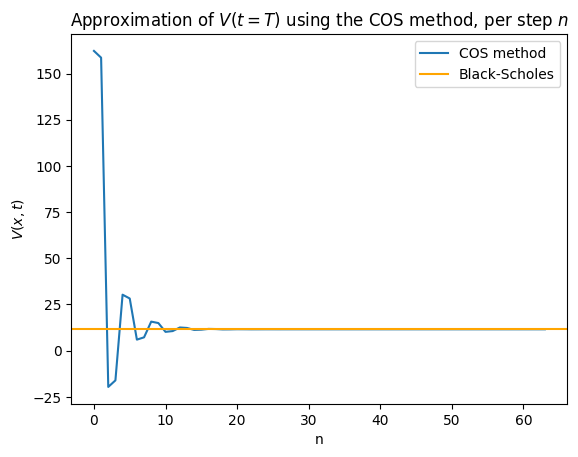

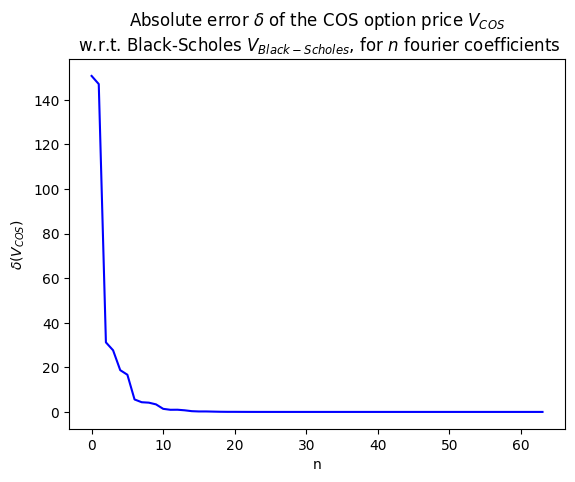

Convergence at 35 (with criteria stopping condition, error < 10^5)


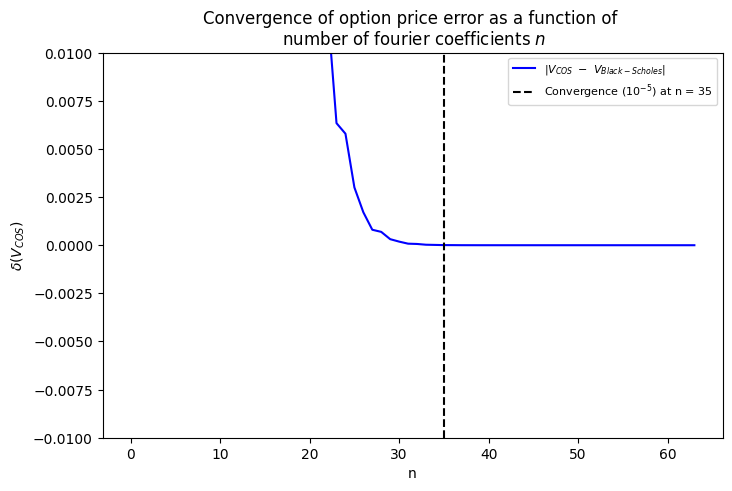

In [10]:
class Cos:
    def __init__(self, T, K, r, S, sigma, N):
        self.T = T
        self.K = K
        self.r = r
        self.S = S
        self.sigma = sigma
        self.N = N
        self.a = np.log(self.S/self.K) + self.r*self.T - 12*np.sqrt((sigma**2)*self.T)
        self.b = np.log(self.S/self.K) + self.r*self.T + 12*np.sqrt((sigma**2)*self.T)
        self.x = np.log(self.S/self.K)

    def black_scholes(self, call=True):
        '''
        Evaluates the Black-Scholes formula at maturity
        '''
        d1 = (np.log(self.S/self.K) + (self.r + 0.5*(self.sigma**2))*self.T)/(self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)
        if call:
            return self.S * norm.cdf(d1) - self.K*np.exp(-self.r*self.T) * norm.cdf(d2)
        else:
            return self.K*np.exp(-self.r*self.T) * norm.cdf(-d2) - self.S * norm.cdf(-d1)
        
    def chi_k(self, c, d, k):
        chi = (1/(1 + (((k*np.pi)/(self.b - self.a))**2))) * (np.cos(k*np.pi*((d - self.a)/(self.b - self.a)))*(np.exp(d))
                                                        - np.cos(k*np.pi*((c - self.a)/(self.b - self.a)))*(np.exp(c))
                                                        + (k*np.pi/(self.b - self.a))*np.sin(k*np.pi*((d - self.a)/(self.b - self.a)))*(np.exp(d))
                                                        - (k*np.pi/(self.b - self.a))*np.sin(k*np.pi*((c - self.a)/(self.b - self.a)))*(np.exp(c)))
    
        return chi
    
    def psi_k(self, c, d, k):
        if k == 0:
            psi = d - c
        else:
            psi = (np.sin(k*np.pi*((d - self.a)/(self.b - self.a))) - np.sin(k*np.pi*((c - self.a)/(self.b - self.a))))* ((self.b - self.a)/(k*np.pi))
        return psi

    def phi_GBM(self, u):
        '''
        characteristic function
        '''
        phi = np.exp(1j*u*(self.r - 0.5*(self.sigma**2))*self.T - (0.5*(self.sigma**2)*self.T*(u**2)))
        return phi
    
    def option_price(self):
        '''
        Performs the COS method using functions self.chi_k, self.psi_k and self.phi_GBM, respectively
        '''
        V_n_list = []
        sum_FG = 0
        for n in range(self.N):
            # calculate coefficients G_k and F_k
            G_k = (2/(self.b - self.a))*self.K *(self.chi_k(c=0, d=self.b, k=n) - self.psi_k(c=0, d=self.b, k=n))
            F_k = (2/(self.b - self.a))* np.real(self.phi_GBM(u=(n*np.pi/(self.b-self.a))) * np.exp(1j*(n*np.pi*(self.x - self.a))/(self.b - self.a)))
            if n == 0:
                F_k *= 0.5
            # calculate the sum over the product F_k*G_k
            sum_FG += F_k * G_k
            # Estimated COS method V at maturity for each n
            V = np.exp(-self.r*self.T) * 0.5*(self.b - self.a) * sum_FG 
            V_n_list.append(V)

        return V_n_list
    
    def convergence(self, V_list, stopping_criterion):
        '''
        Function to find the value and index of convergence of a list
        by taking the difference between the current and the previous step
        and returns these when this difference reaches below a ptovided stopping criterion
        '''
        self.i = 0
        self.stopping_criterion = stopping_criterion
        convergence = stopping_criterion * 10**5
        while convergence > stopping_criterion:
            self.i += 1
            convergence = abs((V_list[self.i] - V_list[self.i-1])/(V_list[self.i-1]))
            convergence_index = self.i-1 
            if self.i == len(V_list) - 1:
                statement = f'V doesn\'t converge for %i steps'%(self.N)
                return statement
        V_convergence = V_list[convergence_index]
        return V_convergence, convergence_index

# initialize Cos class with a set of parameters
cos_method = Cos(T=1.0, K=99.0, r=0.06, S=100.0, sigma=0.2, N=64)

# call COS method and get data for V_COS(n) and analytical V_BS
V_n_list = cos_method.option_price()
V_bs = cos_method.black_scholes()

# error of the COS method
error_array = abs(np.array(V_n_list) - V_bs)
cos_method.convergence(V_n_list, 1e-5)

# print statements showing results
print('V black scholes =', V_bs)
if cos_method.i == cos_method.N - 1:
    print(cos_method.convergence(V_n_list, 1e-5))
else: 
    V_convergence, convergence_index = cos_method.convergence(V_n_list, 1e-5)
print('V convergence =', V_convergence)
print('Convergence (10^(%i)) at step %i'%(np.log10(cos_method.stopping_criterion), convergence_index))
print('V final =', V_n_list[-1])


# plot for the COS method approximated V as a function of N (Fourier Coefficients) as it approaches V_BS
plt.title(r'Approximation of $V(t=T)$ using the COS method, per step $n$')
plt.plot(range(cos_method.N), V_n_list, label='COS method')
# plt.axvline(x=convergence_index, color='k', linestyle= '--', label=r'Convergence ($10^{-5}$) at n = %i'%(convergence_index))
plt.axhline(y=V_bs, color = 'orange', label='Black-Scholes')
plt.xlabel('n')
plt.ylabel(r'$V(x,t)$')
plt.legend()
plt.savefig('Downloads/V_cos_V_BS.png', dpi=200)
plt.show()

# plot for the error of the COS method for estimating V
plt.title('Absolute error $\delta$ of the COS option price $V_{COS}$ \n w.r.t. Black-Scholes $V_{Black-Scholes}$, for $n$ fourier coefficients')
plt.plot(range(cos_method.N), error_array, 'b')
plt.xlabel('n')
plt.ylabel(r'$\delta(V_{COS})$')
plt.savefig('Downloads/Error_cos.png', dpi=200)
plt.show()

# zoomed in version of the above plot
plt.figure(figsize=(8, 5))
plt.title('Convergence of option price error as a function of \n number of fourier coefficients $n$ ')
plt.plot(range(cos_method.N), error_array, 'b', label=r'$|V_{COS}\ -\ V_{Black-Scholes}|$')
plt.xlabel('n')
plt.ylabel(r'$\delta(V_{COS})$')
plt.ylim(-0.01,0.01)

# prints convergence
for i, error in enumerate(error_array):
    if error < 1e-5:
        print(f'Convergence at {i} (with criteria stopping condition, error < 10^5)')
        break
plt.axvline(x=i, color='k', linestyle= '--', label=r'Convergence ($10^{-5}$) at n = %i'%(i))
plt.legend(prop={'size': 8})
plt.savefig('Downloads/Error_cos_zoomed.png', dpi=200)
plt.show()

In [13]:
# Investigation of error for certain values of N. 
# Demonstrating where the error reaches below machine precision, printing 0

N_list = range(100)
cos_method = Cos(T=1.0, K=99.0, r=0.06, S=100.0, sigma=0.2, N=N_list[-1])
V_n_list = cos_method.option_price()
V_bs = cos_method.black_scholes()
error_array = abs(np.array(V_n_list) - V_bs)

for N in N_list:
    print(N, error_array[N-1])

    

0 0.0
1 150.7033395217668
2 147.05276724270635
3 31.19378903740343
4 27.64868527800043
5 18.736092653442874
6 16.677569060185707
7 5.592970111714711
8 4.348503033117391
9 4.154370820381828
10 3.383158432448319
11 1.386659137854906
12 0.9577935905903505
13 0.9858670593172434
14 0.7269680015675508
15 0.3371451957379339
16 0.2095730345510134
17 0.21240813482305398
18 0.14042316259407173
19 0.07107746755808542
20 0.04010615561633557
21 0.038786926290454105
22 0.022788165890707646
23 0.012322847534420589
24 0.006341049320694125
25 0.005792757892089995
26 0.0030015754328740485
27 0.0017110447069974555
28 0.0008042541751773769
29 0.0006928312154208527
30 0.00031453833244832197
31 0.00018747725766665724
32 8.044157672948415e-05
33 6.546695527909208e-05
34 2.589483788639768e-05
35 1.606366639705925e-05
36 6.27609823311559e-06
37 4.842185095554896e-06
38 1.6608297528364346e-06
39 1.069996118374661e-06
40 3.7911293837566973e-07
41 2.784896064866871e-07
42 8.250519201169482e-08
43 5.51802177284344